In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.utils import class_weight
from keras_preprocessing import image as im
tf.random.set_seed(
    5
)

# Loading data

In [3]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    images = []
    for image_name in df['image_name'].values:
        images.append(np.array(im.load_img(image_name, target_size=(224,224))))
    images = np.array(images)
    images = images/255
    annotations = df['annotation'].str.lower().values
    return images, annotations

In [4]:
images, annotations = load_data("../../../../images/", '../../../../emo-at-cap.csv')

# Processing of data

In [5]:
import nltk

In [6]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [7]:
tokenized = [tokenizer.tokenize(i) for i in annotations]

In [8]:
unique_tokens, unique_counts = np.unique(np.hstack(tokenized), return_counts=True)

In [9]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.hstack(tokenized)), np.hstack(tokenized))

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=["'" ',' '-' ... 'youth' 'исходный' 'текст'], y=['the' 'man' 'is' ... 'with' 'some' 'clothes'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [10]:
frequency = sorted(list(zip(unique_tokens, unique_counts)), key = lambda x: x[1])[::-1][:50]

In [11]:
frequency

[('the', 3261),
 ('is', 2031),
 ('man', 1905),
 ('and', 1536),
 ('woman', 1361),
 ('are', 1036),
 ('a', 963),
 ('to', 891),
 ('looks', 751),
 ('happy', 705),
 ('with', 547),
 ('something', 480),
 ('men', 478),
 ('of', 463),
 ('two', 408),
 ('other', 361),
 ('people', 343),
 ('couple', 334),
 (',', 330),
 ('in', 278),
 ('look', 270),
 ('because', 265),
 ('they', 256),
 ('about', 247),
 ('on', 246),
 ('at', 192),
 ('trying', 190),
 ('serious', 189),
 ('women', 184),
 ('each', 179),
 ('together', 176),
 ('by', 175),
 ('having', 171),
 ('flirting', 165),
 ('he', 155),
 ('smiling', 151),
 ('arguing', 141),
 ('angry', 140),
 ('scared', 138),
 ('worried', 137),
 ('hugging', 135),
 ('surprised', 134),
 ('calm', 133),
 ('company', 131),
 ('her', 129),
 ('group', 123),
 ('for', 121),
 ('she', 117),
 ('looking', 117),
 ('his', 115)]

In [12]:
len(unique_tokens)

2162

In [13]:
pad_token = '<PAD>'
start_token = '<S>'
end_token = '<E>'

In [14]:
vocab = dict(zip(unique_tokens,list(range(3,len(unique_tokens)+3))))
vocab[pad_token] = 0
vocab[start_token] = 1
vocab[end_token] = 2

In [15]:
inverse_vocab = dict([(v,k) for k,v in vocab.items()])

In [16]:
def padd(sentences, pad_token, start_token, end_token, maxlen=10):
    padded_sentences = []
    for i in sentences:
        sentence = [start_token] + i + [end_token]
        if len(sentence)>=maxlen+2:
            sentence = sentence[:maxlen+2]
        else:
            sentence = sentence+[pad_token for i in range(maxlen+2-len(sentence))]
        padded_sentences.append(sentence)
    return padded_sentences

In [17]:
padded_sentences = padd(tokenized, pad_token, start_token, end_token, maxlen=10)

In [18]:
np.mean([len(i) for i in padded_sentences])

12.0

In [19]:
indexed = list(map(lambda x: [vocab[i] for i in x],padded_sentences))

In [20]:
images.shape

(3840, 224, 224, 3)

In [21]:
len(class_weights)

2162

In [22]:
class_weights = list(class_weights)
class_weights.insert(0, 1)
class_weights.insert(1, 1)
class_weights.insert(2, 1)

In [23]:
len(class_weights), len(vocab)

(2165, 2165)

In [24]:
class_weights[:4]

[1, 1, 1, 0.21013259327782918]

In [25]:
class_weights = np.array(class_weights)

In [26]:
class_weights.shape

(2165,)

# Model with transfer learning

In [27]:
def calc_size(x, f, s, padding='same'):
    p = 2 if padding=='same' else 1
    return (x-f+2)/s+1

### Convolutional model

In [28]:
import tensorflow.keras.applications as apps


In [29]:
tf.keras.models.load_model('encoder.h5').summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2951

In [1]:
class ConvEncoder(tf.keras.Model):
    def __init__(self, trainable=False, n_finetune=5):
        super(ConvEncoder, self).__init__()
        #building resnet
        resnet = apps.ResNet152V2(include_top=False, weights='imagenet')
        outputs = [i for i in resnet.layers if i.name=='conv4_block5_out'][0]
        inputs = resnet.layers[0]
        self.resnet_extractor = tf.keras.models.Model(inputs=inputs.input, outputs=outputs.output)
        if trainable and n_finetune:
            for layer in self.resnet_extractor.layers[:-n_finetune]:
                layer.trainable = False
        else:
            self.resnet_extractor.trainable = trainable
        
        #batch norm
        self.batch_norm1 =  tf.keras.layers.BatchNormalization()
        self.batch_norm2 =  tf.keras.layers.BatchNormalization()
        self.batch_norm3 =  tf.keras.layers.BatchNormalization()
        #dropout
        self.dropout = tf.keras.layers.Dropout(0.1)
        
        #on top extractors 
        self.conv1 = tf.keras.layers.Conv2D(filters=1024, kernel_size=7, activation='relu',
                               padding='same', name='conv1', strides=(2,2))
        self.conv2 = tf.keras.layers.Conv2D(filters=1024, kernel_size=5, activation='relu',
                                       padding='same', name='conv2', strides=(2,2))
        self.conv3 = tf.keras.layers.Conv2D(filters=512, kernel_size=4, activation='relu',
                                       padding='same', name='conv3', strides=(2,2))
        self.conv4 = tf.keras.layers.Conv2D(filters=512, kernel_size=1, activation='relu',
                                       padding='same', name='conv4', strides=(2,2))
        
        self.conv5 = tf.keras.layers.Conv2D(filters=512, kernel_size=1, activation='relu',
                                       padding='same', name='conv5', strides=(2,2))
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, input):
        resnet_features = self.resnet_extractor(input)
        conv1_out = self.batch_norm1(self.conv1(resnet_features))
        conv2_out = self.batch_norm2(self.conv2(conv1_out))
        conv3_out = self.batch_norm3(self.conv3(conv2_out))
        conv4_out = self.conv4(conv3_out)
        conv5_out = self.conv5(conv3_out)
        return [self.dropout(self.flatten(conv4_out)), self.dropout(self.flatten(conv5_out))]

NameError: name 'tf' is not defined

In [31]:
conv_encoder = ConvEncoder()

In [32]:
conv_res = conv_encoder(np.expand_dims(images[0],axis=0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [33]:
conv_res

[<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
 array([[ 3.892925  ,  1.6916088 ,  0.00570858,  1.0112987 ,  0.4297652 ,
          0.96775097, -0.3451106 , -0.996479  , -0.02044451,  1.7852882 ,
         -0.03025961,  2.1571085 ,  1.8869938 ,  0.20012403,  1.4193159 ,
          0.45365408,  1.2579775 ,  0.7760458 , -0.9947332 ,  0.91881716,
          1.3528395 , -0.8621257 ,  0.87626857, -0.8479652 , -0.76765466,
          1.284748  ,  0.3093021 ,  0.45954576,  2.473575  ,  1.9502547 ,
          1.8988252 , -0.9993044 ,  1.6085855 ,  0.4710661 ,  0.5903698 ,
          2.1000845 , -0.60710055,  0.5455965 , -0.26280105,  0.03406882,
          0.3795948 ,  0.24454258,  0.23393305, -0.94134235,  1.353725  ,
         -0.96302044,  0.54988116,  0.56207925,  1.8568035 ,  3.2081697 ,
         -0.8813664 ,  2.3474717 ,  2.749933  ,  0.41212484, -0.99736756,
          1.657018  , -0.99869317,  2.4560733 ,  0.7414487 ,  0.7478813 ,
         -0.25330955,  2.8545842 , -0.98293906, -0.99697936, 

### LSTM model

### making w2v embeddings

In [34]:
!pip install gensim

     |████████████████████████████████| 23.9 MB 17.4 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 9.1 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [35]:
import gensim.downloader as api

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
w2v_embeddings = api.load('word2vec-google-news-300')

[=======-------------------------------------------] 14.2% 236.2/1662.8MB downloaded

In [ ]:
def build_embeddings(vocab, word_vectors, embed_dim):
    emb_matrix = np.zeros(shape=(len(vocab)+ 1 , embed_dim), dtype='float32')
    count = 0
    for word, i in vocab.items():
        try:
            emb_matrix[i, :] = word_vectors.get_vector(word)
        except:
            count += 1
            emb_matrix[i, :] = np.random.uniform(-0.1, 0.1, embed_dim)
    print('{} words are out of vocabulary：'.format(count))
    return emb_matrix


In [ ]:
w2v_embeddings = build_embeddings(vocab, w2v_embeddings, 300)

### building model

In [ ]:
class LSTMDecoder(tf.keras.Model):
    def __init__(self, max_tokens, lstm_units, embeddings=None, dim=128):
        super(LSTMDecoder, self).__init__()
        self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=dim, name='embeddings',
                                                   weights=[embeddings])
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6, name='layer_normalization')
        self.lstm = tf.keras.layers.LSTM(units=lstm_units, return_state=True, name='lstm_decoder', recurrent_dropout=0.3)
        self.output_dense = tf.keras.layers.Dense(units=max_tokens)
        
    def call(self, input, features):
        embedded = self.dropout(self.embeddings(input))
        result_lstm, state_h, state_c = self.lstm(embedded, initial_state=features)
        normalized = self.layer_norm(result_lstm)
        logits = self.output_dense(normalized)
        return logits, [state_h, state_c]

In [ ]:
lstm_decoder = LSTMDecoder(len(inverse_vocab), conv_res[0].shape[1], w2v_embeddings, dim=300)

### Training

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',
                                                                         from_logits=True)
lr_value = 1e-4
reduction_power = 10
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_value)
with_weights = False

In [ ]:
epochs = 30
batch_size = 64
patience_epochs = 2

In [42]:
def loss_function(real, pred, loss_weights):
        mask = tf.math.logical_not(tf.math.equal(real, vocab[pad_token]))
        loss_ = loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_weights = tf.cast(loss_weights, dtype=loss_.dtype)
        loss_*=loss_weights
        return loss_

In [43]:
@tf.function
def train_step(image, target, lengths, optimizer):

    with tf.GradientTape() as tape:
        initial_state = conv_encoder(image)
        # Teacher forcing - feeding the target as the next input
        batched_loss = []
        for t in range(1, target.shape[1]):
            
            dec_input = tf.expand_dims(target[:, t-1], 1)
            result, initial_state = lstm_decoder(input=dec_input, features=initial_state)
            weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
            weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
            batched_loss.append(loss_function(target[:, t], result, weights))
        batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
        batched_loss = tf.reduce_sum(batched_loss, axis=1)
        lengths = tf.cast(lengths, dtype=batched_loss.dtype)
        loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)

    variables = conv_encoder.trainable_variables + lstm_decoder.trainable_variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return loss, perplexity

In [44]:
@tf.function
def evaluate(image, target, lengths, optimizer):

    initial_state = conv_encoder(image)
    # Teacher forcing - feeding the target as the next input
    batched_loss = []
    for t in range(1, target.shape[1]):

        dec_input = tf.expand_dims(target[:, t-1], 1)
        result, initial_state = lstm_decoder(input=dec_input, features=initial_state)
        weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
        weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
        batched_loss.append(loss_function(target[:, t], result, weights))
    
    batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
    batched_loss = tf.reduce_sum(batched_loss, axis=1)
    lengths = tf.cast(lengths, dtype=batched_loss.dtype)
    loss = tf.reduce_mean(batched_loss / lengths)
    perplexity = tf.exp(loss)


    return loss, perplexity

In [45]:
train_images, val_images, train_sequences, val_sequences =  train_test_split(images, indexed, test_size=0.2, random_state=10)
val_images, test_images, val_sequences, test_sequences =  train_test_split(val_images, val_sequences, test_size=0.5, random_state=10)

In [46]:
train_length = (np.array(train_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [47]:
val_length = (np.array(val_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [48]:
test_length = (np.array(test_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [49]:
train_images = np.array(np.array_split(train_images, len(train_images)//batch_size))
test_images = np.array(np.array_split(test_images, len(test_images)//batch_size))
val_images = np.array(np.array_split(val_images, len(val_images)//batch_size))

train_sequences = np.array(np.array_split(train_sequences, len(train_sequences)//batch_size))
test_sequences = np.array(np.array_split(test_sequences, len(test_sequences)//batch_size))
val_sequences = np.array(np.array_split(val_sequences, len(val_sequences)//batch_size))

train_length = np.array(np.array_split(train_length, len(train_length)//batch_size))
test_length = np.array(np.array_split(test_length, len(test_length)//batch_size))
val_length = np.array(np.array_split(val_length, len(val_length)//batch_size))


In [50]:
train_images.shape, train_sequences.shape, train_length.shape

((24, 128, 224, 224, 3), (24, 128, 12), (24, 128))

In [51]:
!pip install tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [52]:
if not with_weights:
    class_weights = np.array([1 for i in range(len(class_weights))])

In [53]:
from tqdm import tqdm

In [54]:
train_loss = []
train_perplexity = []
val_loss = []
val_perplexity = []
overfit_epochs = 0
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_perplexity = 0
    epoch_val_loss = 0
    epoch_val_perplexity = 0
    for batch_train_images, batch_train_sequences, batched_train_length in tqdm(zip(train_images,train_sequences,train_length)):
        batched_train_loss, batched_train_perplexity = train_step(batch_train_images,batch_train_sequences,batched_train_length, optimizer)
        epoch_train_loss+=batched_train_loss
        epoch_train_perplexity+=batched_train_perplexity
    epoch_train_loss = epoch_train_loss/train_images.shape[0]
    epoch_train_perplexity = epoch_train_perplexity/train_images.shape[0]
    train_loss.append(epoch_train_loss)
    train_perplexity.append(epoch_train_perplexity)
    print('Finished epoch {}; Train loss : {}; Train perplexity : {}'.format(epoch,epoch_train_loss,epoch_train_perplexity))
    for batch_val_images, batch_val_sequences, batched_val_length in zip(val_images,val_sequences,val_length):
        batched_val_loss, batched_val_perplexity = evaluate(batch_val_images, batch_val_sequences, batched_val_length, optimizer)
        epoch_val_loss+=batched_val_loss
        epoch_val_perplexity+=batched_val_perplexity
    epoch_val_loss = epoch_val_loss/val_images.shape[0]
    epoch_val_perplexity = epoch_val_perplexity/val_images.shape[0]
    val_perplexity.append(epoch_val_perplexity)
    val_loss.append(epoch_val_loss)
    print('Validation loss : {}; Validation perplexity : {}'.format(epoch_val_loss,epoch_val_perplexity))
    if len(val_loss)>=2 and val_loss[-2]<val_loss[-1]:
        overfit_epochs+=1
    else:
        overfit_epochs=0
    if overfit_epochs==patience_epochs:
        lr_value/=reduction_power
        optimizer.lr.assign(lr_value)
        print('There was no improvement in validation loss for {} epochs, thus reducing learning rate'.format(patience_epochs))

24it [01:24,  3.54s/it]


Finished epoch 0; Train loss : 6.4712700843811035; Train perplexity : 1230.5411376953125


0it [00:00, ?it/s]

Validation loss : 5.634289264678955; Validation perplexity : 279.9302062988281


24it [00:57,  2.40s/it]


Finished epoch 1; Train loss : 5.385011196136475; Train perplexity : 221.0137481689453


0it [00:00, ?it/s]

Validation loss : 5.231902599334717; Validation perplexity : 187.3235321044922


24it [00:57,  2.40s/it]


Finished epoch 2; Train loss : 5.1012492179870605; Train perplexity : 165.53048706054688


0it [00:00, ?it/s]

Validation loss : 5.006351947784424; Validation perplexity : 149.55496215820312


24it [00:57,  2.39s/it]


Finished epoch 3; Train loss : 4.874889373779297; Train perplexity : 132.1216583251953


0it [00:00, ?it/s]

Validation loss : 4.7857232093811035; Validation perplexity : 120.24201202392578


24it [00:57,  2.40s/it]


Finished epoch 4; Train loss : 4.60084867477417; Train perplexity : 100.65353393554688


0it [00:00, ?it/s]

Validation loss : 4.5565104484558105; Validation perplexity : 95.89466094970703


24it [00:57,  2.41s/it]


Finished epoch 5; Train loss : 4.297177791595459; Train perplexity : 74.34029388427734


0it [00:00, ?it/s]

Validation loss : 4.286541938781738; Validation perplexity : 73.50743103027344


24it [00:57,  2.40s/it]


Finished epoch 6; Train loss : 4.044796466827393; Train perplexity : 57.67629623413086


0it [00:00, ?it/s]

Validation loss : 4.1453680992126465; Validation perplexity : 63.90157699584961


24it [00:57,  2.39s/it]


Finished epoch 7; Train loss : 3.8343656063079834; Train perplexity : 46.66157531738281


0it [00:00, ?it/s]

Validation loss : 3.9971530437469482; Validation perplexity : 55.18397521972656


24it [00:57,  2.40s/it]


Finished epoch 8; Train loss : 3.6565961837768555; Train perplexity : 39.06312942504883


0it [00:00, ?it/s]

Validation loss : 3.8667728900909424; Validation perplexity : 48.5029182434082


24it [00:58,  2.42s/it]


Finished epoch 9; Train loss : 3.5046684741973877; Train perplexity : 33.52306365966797


0it [00:00, ?it/s]

Validation loss : 3.8053512573242188; Validation perplexity : 45.6049690246582


24it [00:57,  2.39s/it]


Finished epoch 10; Train loss : 3.3494598865509033; Train perplexity : 28.717384338378906


0it [00:00, ?it/s]

Validation loss : 3.7313449382781982; Validation perplexity : 42.3392448425293


24it [00:57,  2.42s/it]


Finished epoch 11; Train loss : 3.2208826541900635; Train perplexity : 25.236291885375977


0it [00:00, ?it/s]

Validation loss : 3.692493438720703; Validation perplexity : 40.829742431640625


24it [00:57,  2.41s/it]


Finished epoch 12; Train loss : 3.0852596759796143; Train perplexity : 22.03723907470703


0it [00:00, ?it/s]

Validation loss : 3.649590492248535; Validation perplexity : 39.00863265991211


24it [00:58,  2.42s/it]


Finished epoch 13; Train loss : 2.959502935409546; Train perplexity : 19.421720504760742


0it [00:00, ?it/s]

Validation loss : 3.635546922683716; Validation perplexity : 38.49481201171875


24it [00:57,  2.41s/it]


Finished epoch 14; Train loss : 2.8218421936035156; Train perplexity : 16.937088012695312


0it [00:00, ?it/s]

Validation loss : 3.57352352142334; Validation perplexity : 36.24365234375


24it [00:57,  2.39s/it]


Finished epoch 15; Train loss : 2.7065675258636475; Train perplexity : 15.076445579528809


0it [00:00, ?it/s]

Validation loss : 3.5865976810455322; Validation perplexity : 36.645938873291016


24it [00:57,  2.40s/it]


Finished epoch 16; Train loss : 2.569758176803589; Train perplexity : 13.153786659240723


0it [00:00, ?it/s]

Validation loss : 3.5780467987060547; Validation perplexity : 36.48252487182617


24it [00:57,  2.41s/it]


Finished epoch 17; Train loss : 2.441436529159546; Train perplexity : 11.56926441192627


0it [00:00, ?it/s]

Validation loss : 3.578563690185547; Validation perplexity : 36.402469635009766


24it [00:57,  2.41s/it]


Finished epoch 18; Train loss : 2.3356189727783203; Train perplexity : 10.393445014953613


0it [00:00, ?it/s]

Validation loss : 3.532646894454956; Validation perplexity : 34.760684967041016


24it [00:57,  2.42s/it]


Finished epoch 19; Train loss : 2.2084267139434814; Train perplexity : 9.156901359558105


0it [00:00, ?it/s]

Validation loss : 3.5316412448883057; Validation perplexity : 34.76924133300781


24it [00:58,  2.44s/it]


Finished epoch 20; Train loss : 2.065084934234619; Train perplexity : 7.922544956207275


0it [00:00, ?it/s]

Validation loss : 3.6331470012664795; Validation perplexity : 38.57615280151367


24it [00:57,  2.39s/it]


Finished epoch 21; Train loss : 1.9593915939331055; Train perplexity : 7.135913372039795


0it [00:00, ?it/s]

Validation loss : 3.657855749130249; Validation perplexity : 39.29267883300781
There was no improvement in validation loss for 2 epochs, thus reducing learning rate


24it [00:57,  2.38s/it]


Finished epoch 22; Train loss : 1.8005709648132324; Train perplexity : 6.110279083251953


0it [00:00, ?it/s]

Validation loss : 3.481348752975464; Validation perplexity : 33.059104919433594


24it [00:57,  2.41s/it]


Finished epoch 23; Train loss : 1.6961997747421265; Train perplexity : 5.477230548858643


0it [00:00, ?it/s]

Validation loss : 3.4900076389312744; Validation perplexity : 33.338905334472656


24it [00:57,  2.42s/it]


Finished epoch 24; Train loss : 1.6555243730545044; Train perplexity : 5.257919788360596


0it [00:00, ?it/s]

Validation loss : 3.4967496395111084; Validation perplexity : 33.555816650390625
There was no improvement in validation loss for 2 epochs, thus reducing learning rate


24it [00:58,  2.42s/it]


Finished epoch 25; Train loss : 1.6358122825622559; Train perplexity : 5.156921863555908


0it [00:00, ?it/s]

Validation loss : 3.493562936782837; Validation perplexity : 33.44453048706055


24it [00:57,  2.40s/it]


Finished epoch 26; Train loss : 1.6239022016525269; Train perplexity : 5.093959331512451


0it [00:00, ?it/s]

Validation loss : 3.4929943084716797; Validation perplexity : 33.41969680786133


24it [00:58,  2.43s/it]


Finished epoch 27; Train loss : 1.6171478033065796; Train perplexity : 5.0588178634643555


0it [00:00, ?it/s]

Validation loss : 3.493191957473755; Validation perplexity : 33.422245025634766


24it [00:57,  2.41s/it]


Finished epoch 28; Train loss : 1.6121066808700562; Train perplexity : 5.032924175262451


0it [00:00, ?it/s]

Validation loss : 3.493696928024292; Validation perplexity : 33.43673324584961
There was no improvement in validation loss for 2 epochs, thus reducing learning rate


24it [00:58,  2.42s/it]


Finished epoch 29; Train loss : 1.6068841218948364; Train perplexity : 5.006883144378662
Validation loss : 3.493744134902954; Validation perplexity : 33.43805694580078


# Viewing and saving results

In [55]:
df = pd.DataFrame()
model_name = 'conv_lstm_transfer_learning_w2v_resnet_fixed_size'
df['train_perplexity'] = [i.numpy() for i in train_perplexity]
df['val_perplexity'] = [i.numpy() for i in val_perplexity]
df['train_loss'] = [i.numpy() for i in train_loss]
df['val_loss'] = [i.numpy() for i in val_loss]


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

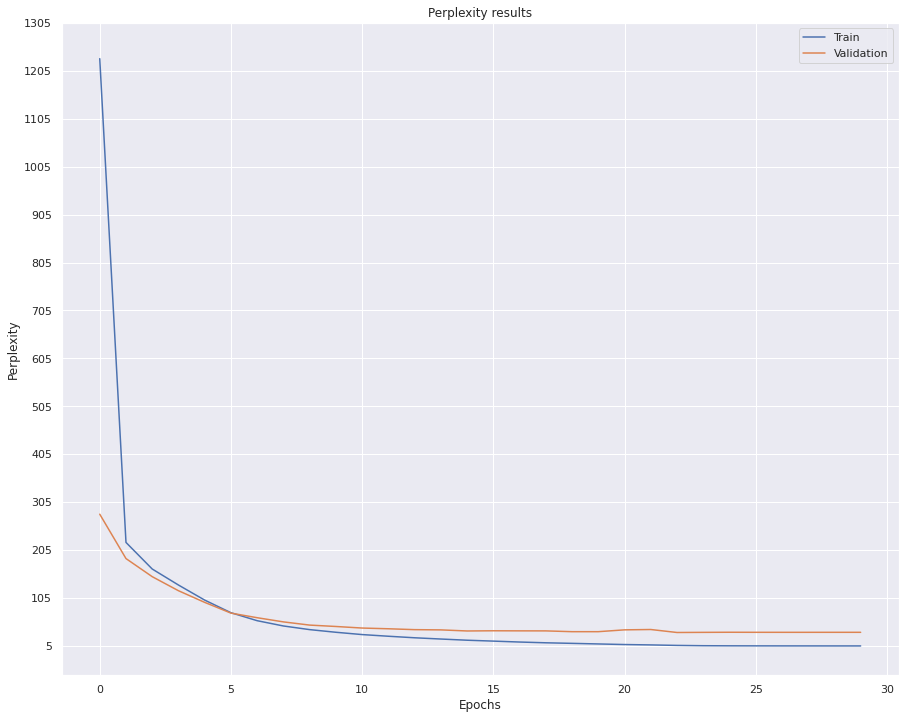

In [57]:
plt.figure(figsize=(15,12))
plt.title('Perplexity results')
plt.plot(df['train_perplexity'])
plt.plot(df['val_perplexity'])
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.yticks(np.arange(min(df['train_perplexity']), max(df['train_perplexity'])+100,100))
plt.legend(['Train', 'Validation']);

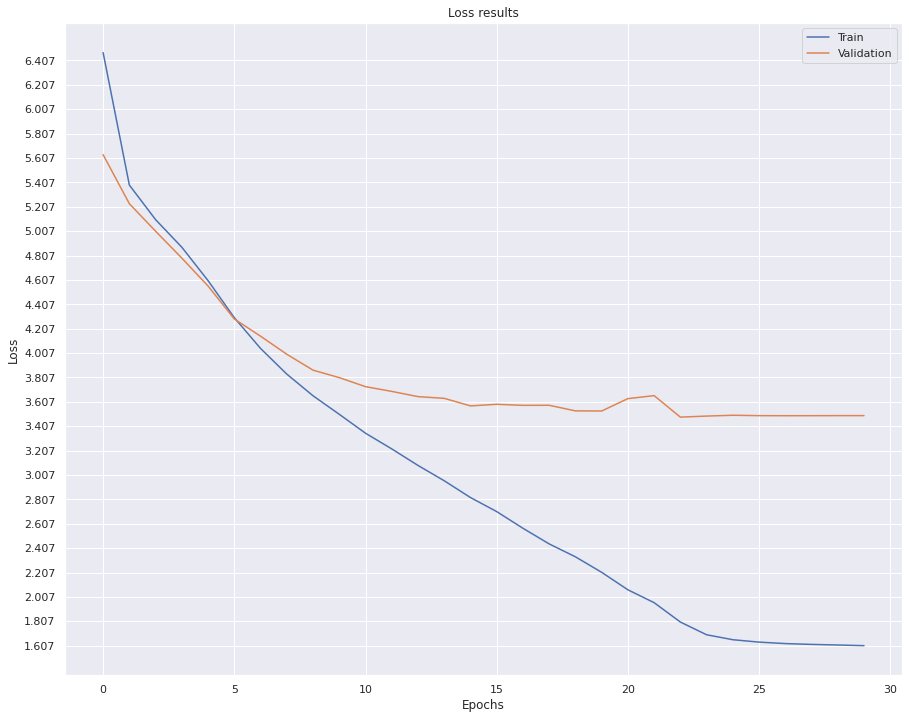

In [58]:
plt.figure(figsize=(15,12))
plt.title('Loss results')
plt.plot(df['train_loss'])
plt.plot(df['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(min(df['train_loss']),max(df['train_loss']),0.2))
plt.legend(['Train', 'Validation']);

# Testing model

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
class Decoder:
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = None):
        self.encoder = encoder
        self.decoder = decoder
        self.max_len = max_len if max_len else 100
        self.start_token = start_token
        self.end_token = end_token

    def decode(self, input):
        pass


class GreedyDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input):
        initial_state = self.encoder(np.expand_dims(input, axis=0))
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = self.start_token
        res = []
        while True:
            # Sample a token
            output, initial_state = self.decoder(target_seq,initial_state)
            sampled_token_index = np.argmax(tf.nn.softmax(output.numpy()))
            if len(res) > self.max_len or sampled_token_index == self.end_token:
                break

            res.append(sampled_token_index)

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

       
        return res


In [61]:
class BeamSearchDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input, beam_size=3):
        start = [self.start_token]
        initial_state = self.encoder(np.expand_dims(input,axis=0))


        start_word = [[start, 0.0, initial_state]]

        while len(start_word[0][0]) < self.max_len:
            temp = []
            for s in start_word:
                target_seq = np.array([[s[0][-1]]])
                initial_state = s[-1]
                output, initial_state = self.decoder(target_seq, initial_state)
                output = np.hstack(output)
                output = tf.nn.softmax(output).numpy()
                word_preds = np.argsort(output)[-beam_size:]

                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += output[w]
                    temp.append([next_cap, prob, initial_state])

            start_word = temp
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
            # Getting the top words
            start_word = start_word[-beam_size:]

        start_word = start_word[-1][0]

        final_caption = []

        for i in start_word:
            if i != self.end_token:
                final_caption.append(i)
            else:
                break
        return final_caption[1:]

In [62]:
def predict(data, decoder, inverse_vocab,
           beam_size=None):
    if beam_size:
        result = decoder.decode(data, beam_size=beam_size)
    else:
        result = decoder.decode(data)
    return ' '.join([inverse_vocab[i] for i in result])

In [63]:
greedy_decoder = GreedyDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=10)

In [64]:
beam_decoder = BeamSearchDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=10)

In [65]:
images.shape

(3840, 224, 224, 3)

In [66]:
idx = np.random.choice(range(len(images)))
sample = images[idx]

woman looks ironic and confident and man looks indifferent


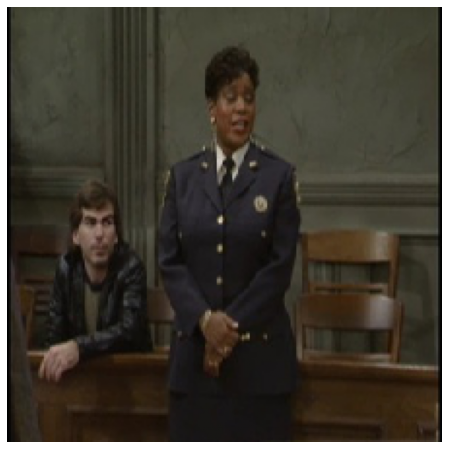

In [67]:
plt.figure(figsize=(8,8))
plt.imshow(sample)
plt.grid([])
plt.axis('off');
print(annotations[idx])

In [68]:
predict(sample, greedy_decoder, inverse_vocab)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



'the man is trying to shoot somebody'

In [69]:
predict(sample, beam_decoder, inverse_vocab, beam_size=3)

'the man is flirting with the woman'

In [70]:
predict(sample, beam_decoder, inverse_vocab, beam_size=5)

'the man is flirting with the woman'

In [71]:
predict(sample, beam_decoder, inverse_vocab, beam_size=7)

'the man is flirting with the woman'

In [72]:
predict(sample, beam_decoder, inverse_vocab, beam_size=10)

'the man is flirting with the woman'

# Blue score calculation

In [73]:
from nltk.translate.bleu_score import sentence_bleu


### making predictions on test dataset with beam_size of 5

In [74]:
test_predictions = []
for batch in tqdm(test_images):
    for image in batch:
        result = predict(image, beam_decoder, inverse_vocab, beam_size=5)
        test_predictions.append(result)

100%|██████████| 3/3 [03:48<00:00, 76.16s/it]


In [75]:
test_predictions = [i.split(' ') for i in test_predictions]

In [76]:
reshaped_sequences = test_sequences.reshape(test_sequences.shape[0]*test_sequences.shape[1],-1)

In [77]:
test_sentences = []
for i in reshaped_sequences:
    tmp = []
    for word in i:
        if word!=0 and word!=1 and word!=2:
            tmp.append(inverse_vocab[word])
    test_sentences.append(tmp)

In [78]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction))
print('Overall bleu score on test data : {}'.format(np.mean(bleu_score)))
df['overall_bleu'] = np.mean(bleu_score)*100

Overall bleu score on test data : 0.04963496716276996


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho

In [79]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(1,)))
print('Bleu score on test data for n-gram = 1 : {}'.format(np.mean(bleu_score)))
df['n1_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 1 : 0.2791644731360667


In [80]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,1)))
print('Bleu score on test data for n-gram = 2 : {}'.format(np.mean(bleu_score)))
df['n2_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 2 : 0.12719220071713225


In [81]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,1)))
print('Bleu score on test data for n-gram = 3 : {}'.format(np.mean(bleu_score)))
df['n3_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 3 : 0.06559554592661036


In [82]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,0,1)))
print('Bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['n4_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 4 : 0.0431603769429324


In [83]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0.25,0.25,0.25,0.25)))
print('Acuumulated bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['acc_bleu'] = np.mean(bleu_score)*100

Acuumulated bleu score on test data for n-gram = 4 : 0.04963496716276996


In [84]:
df.head()

,train_perplexity,val_perplexity,train_loss,val_loss,overall_bleu,n1_bleu,n2_bleu,n3_bleu,n4_bleu,acc_bleu
0,1230.541138,279.930206,6.471270,5.634289,4.963497,27.916447,12.71922,6.559555,4.316038,4.963497
1,221.013748,187.323532,5.385011,5.231903,4.963497,27.916447,12.71922,6.559555,4.316038,4.963497
2,165.530487,149.554962,5.101249,5.006352,4.963497,27.916447,12.71922,6.559555,4.316038,4.963497
3,132.121658,120.242012,4.874889,4.785723,4.963497,27.916447,12.71922,6.559555,4.316038,4.963497
4,100.653534,95.894661,4.600849,4.556510,4.963497,27.916447,12.71922,6.559555,4.316038,4.963497


In [85]:
df.to_csv('{}_logs.csv'.format(model_name),index=False)

In [86]:
conv_encoder.save_weights('{}_encoder.h5'.format(model_name))

In [87]:
lstm_decoder.save_weights('{}_decoder.h5'.format(model_name))

# Predictions on own data

In [102]:
img = np.array(im.load_img('lauging_people.jpeg', target_size=(224,224)))/255

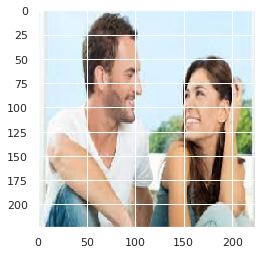

In [103]:
plt.imshow(img)

In [104]:
predict(img, greedy_decoder, inverse_vocab)

'a man and couple is having fun'

In [105]:
predict(img, beam_decoder, inverse_vocab, beam_size=3)

'two men are worried about something'

In [106]:
predict(img, beam_decoder, inverse_vocab, beam_size=5)

'two men are worried about something'

In [107]:
predict(img, beam_decoder, inverse_vocab, beam_size=7)

'two men are trying to shoot somebody'

In [108]:
predict(img, beam_decoder, inverse_vocab, beam_size=10)

'two men are trying to shoot somebody'